In [1]:
import numpy as np
import pandas as pd
from math import sqrt
from numpy import concatenate
import matplotlib.pyplot as plt
%matplotlib inline

from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import StandardScaler

Using TensorFlow backend.


In [2]:
def readCsvToDF(path):
    dataSeries = pd.read_csv(path)
    dataSeries = dataSeries.rename(columns={'Unnamed: 0': 'Time'})
    TimeIndex = dataSeries['Time']
    dataSeries.index = pd.to_datetime(TimeIndex)
    dataSeries = dataSeries[::-1]
    dataSeries = dataSeries.drop('Time', axis=1)
    return dataSeries

# convert series to supervised learning
# data - данные
# n_in - лаг
# n_out - количество таргетов
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
      
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# Loading the DataSet

In [3]:
# testing days = 10
dataSet = readCsvToDF('Data/dataset.csv')
trainData = dataSet[:-24*10*2]
testingData = dataSet[-24*10*2:]
dataSet.shape

(1717, 9)

# Designing Model

In [12]:
n_hours, n_target = 24*10, 24*10

# Читаем данные
dataset = trainData
test_ds = testingData

#dataset = old_dataset#stat_data.drop(stat_data.index[0], axis=0)
#print(dataset)

#dataset = read_csv('resampled_PV18.csv', header=0, index_col=0)
# Берем значения
values = dataset.values
test_values = test_ds.values

#print(values)

# Задаем тип данных
values = values.astype('float32')
test_values = test_values.astype('float32')

print('values: ', values.shape)
print('test: ', test_values.shape)

# Нормируем данные на 0, 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

test_scaler = MinMaxScaler(feature_range=(0, 1))
test_scaled = test_scaler.fit_transform(test_values)

#scaler = StandardScaler()
#scaled = scaler.fit_transform(values)


# Преобразуем данные в соответствии с заданным шагом
reframed = series_to_supervised(scaled, n_hours, n_target)
test_reframed = series_to_supervised(test_scaled, n_hours, n_target)

reframed.shape

values:  (1237, 9)
test:  (480, 9)


(758, 4320)

In [13]:
n_days, n_valid_days = 31, 7

# Подготавливаем выборку для теста и обучения
values = reframed.values
test_values = test_reframed.values

n_train_hours = n_days * 24 #n_hours
n_valid_hours = n_valid_days * 24

train = values[:n_train_hours, :]
valid = values[n_train_hours:, :]#n_train_hours+n_valid_hours, :]
test = test_values #values[n_train_hours+n_valid_hours:, :]

# Разбиение значений выборки на вход/выход
#n_obj = n_hours * n_features
train_X, train_y = train[:, :-9*n_target], train[:, -9*n_target:]
valid_X, valid_y = valid[:, :-9*n_target], valid[:, -9*n_target:]
test_X, test_y = test[:,:-9*n_target], test[:, -9*n_target:]

# reshape input to de 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
valid_X = valid_X.reshape((valid_X.shape[0], 1, valid_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print('Train: ', train_X.shape, valid_X.shape,test_X.shape, '\nTest: ', train_y.shape, valid_y.shape,test_y.shape)

Train:  (744, 1, 2160) (14, 1, 2160) (1, 1, 2160) 
Test:  (744, 2160) (14, 2160) (1, 2160)


Train on 744 samples, validate on 14 samples
Epoch 1/100
 - 14s - loss: 0.2145 - val_loss: 0.1437
Epoch 2/100
 - 9s - loss: 0.1587 - val_loss: 0.1249
Epoch 3/100
 - 10s - loss: 0.1337 - val_loss: 0.1440
Epoch 4/100
 - 9s - loss: 0.1208 - val_loss: 0.1361
Epoch 5/100
 - 10s - loss: 0.1109 - val_loss: 0.1257
Epoch 6/100
 - 10s - loss: 0.1111 - val_loss: 0.1203
Epoch 7/100
 - 9s - loss: 0.1106 - val_loss: 0.1190
Epoch 8/100
 - 10s - loss: 0.1095 - val_loss: 0.1214
Epoch 9/100
 - 9s - loss: 0.1076 - val_loss: 0.1216
Epoch 10/100
 - 10s - loss: 0.1054 - val_loss: 0.1183
Epoch 11/100
 - 10s - loss: 0.1049 - val_loss: 0.1170
Epoch 12/100
 - 9s - loss: 0.1042 - val_loss: 0.1169
Epoch 13/100
 - 9s - loss: 0.1026 - val_loss: 0.1146
Epoch 14/100
 - 9s - loss: 0.1014 - val_loss: 0.1146
Epoch 15/100
 - 10s - loss: 0.1000 - val_loss: 0.1146
Epoch 16/100
 - 10s - loss: 0.0989 - val_loss: 0.1138
Epoch 17/100
 - 10s - loss: 0.0981 - val_loss: 0.1144
Epoch 18/100
 - 10s - loss: 0.0976 - val_loss: 0.1126

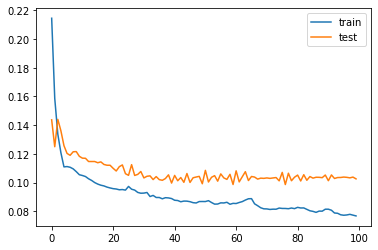

In [14]:
from keras.models import model_from_json
#from keras.callbacks import ModelCheckpoint

# design network
model = Sequential()
model.add(LSTM(2160, activation='sigmoid', input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(2160, activation='sigmoid'))


#model.add(LSTM(240, activation='sigmoid', input_shape=(train_X.shape[1], train_X.shape[2])))
#model.add(Dense(2160, activation='sigmoid'))
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, 
                    epochs=100, 
                    batch_size=240, 
                    validation_data=(valid_X, valid_y), 
                    verbose=2,
                    #callbacks=[checkpoint],
                    shuffle=False)

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# Forecasting

In [15]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for forecast
#inv_yhat = concatenate((yhat, test_X[:, :]),axis=1)

#inv_yhat = yhat
column = yhat.shape[1]
inv_yhat = np.zeros_like(yhat[:,0]).reshape(-1,1)

for i in range(column//9):
    inv_yhat_buf = test_scaler.inverse_transform(yhat[:, i*9:(i+1)*9])
    inv_yhat = np.hstack((inv_yhat, inv_yhat_buf))
inv_yhat = inv_yhat[:, 1:]
    
# inver scaling for actual
test_y = test_y.reshape((test_y.shape[0],test_y.shape[1]))
#inv_y = concatenate((test_y, test_X[:, :]), axis=1)
#inv_y = test_y
inv_y = np.zeros_like(test_y[:,0]).reshape(-1,1)
for i in range(column//9):
    inv_y_buf = test_scaler.inverse_transform(test_y[:, i*9:(i+1)*9])
    inv_y = np.hstack((inv_y, inv_y_buf[:,:]))
inv_y = inv_y[:, 1:]
    
# calculate RMSE
for i in range(9):
    rmse = sqrt(mean_squared_error(inv_y[:,i::9].T, inv_yhat[:,i::9].T))
    r2 = r2_score(inv_y[:,i::9].T, inv_yhat[:,i::9].T)
    print('Test RMSE: %.3f' % rmse)
    print('Test R2: %.3f' % r2)

Test RMSE: 271.745
Test R2: -1.006
Test RMSE: 11.090
Test R2: -0.531
Test RMSE: 11.112
Test R2: -2.286
Test RMSE: 19.085
Test R2: -0.407
Test RMSE: 27.157
Test R2: -0.083
Test RMSE: 20.532
Test R2: -0.711
Test RMSE: 0.000
Test R2: 0.000
Test RMSE: 240.698
Test R2: -1.254
Test RMSE: 228.113
Test R2: -1.145


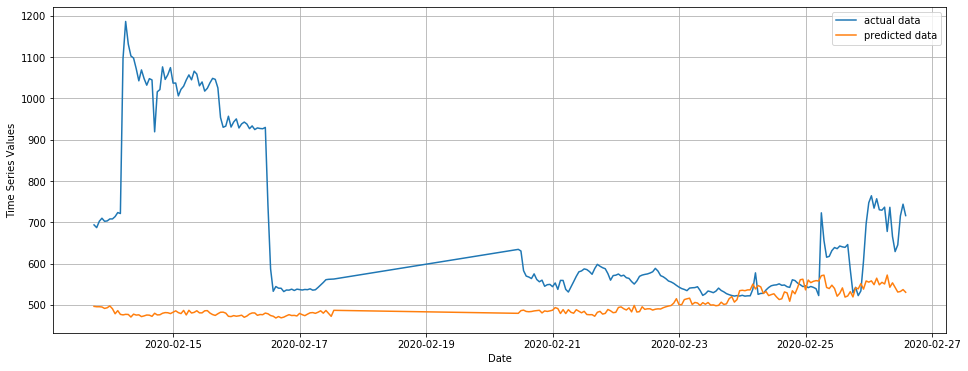

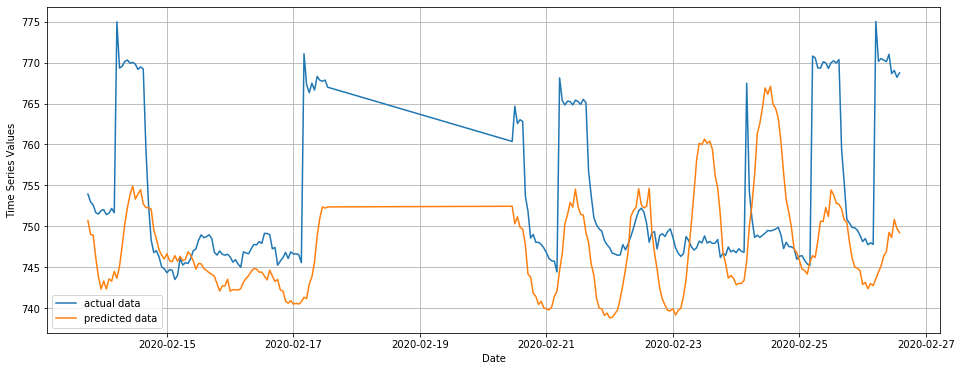

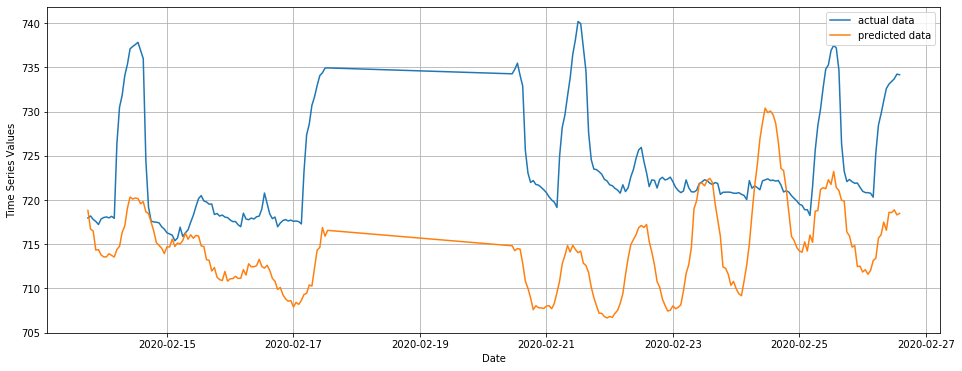

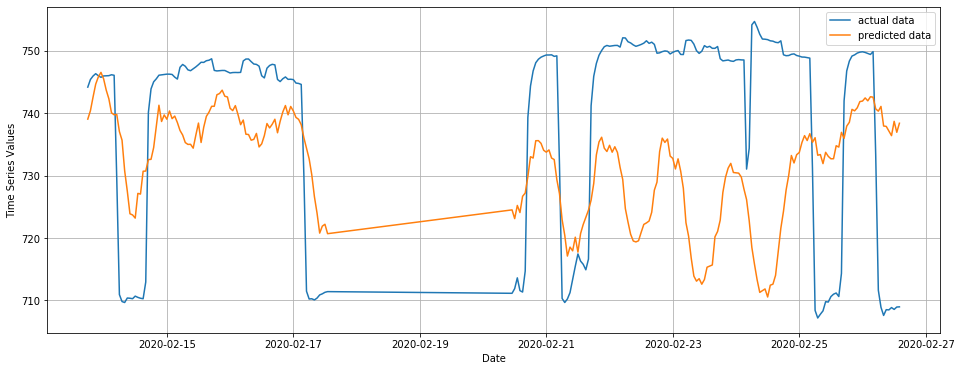

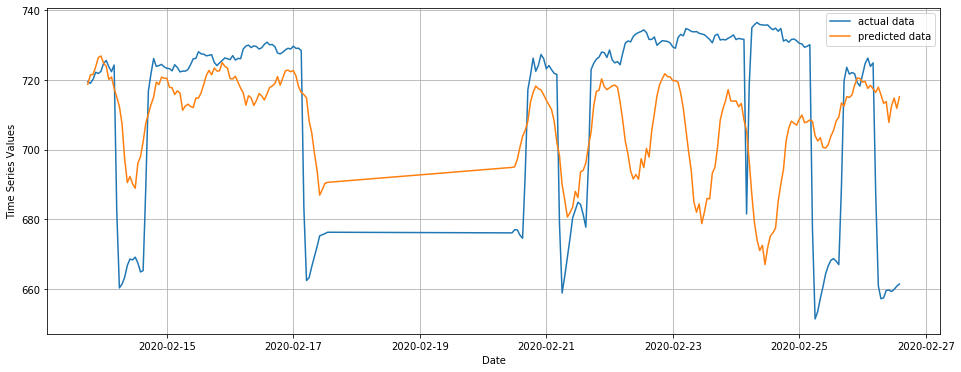

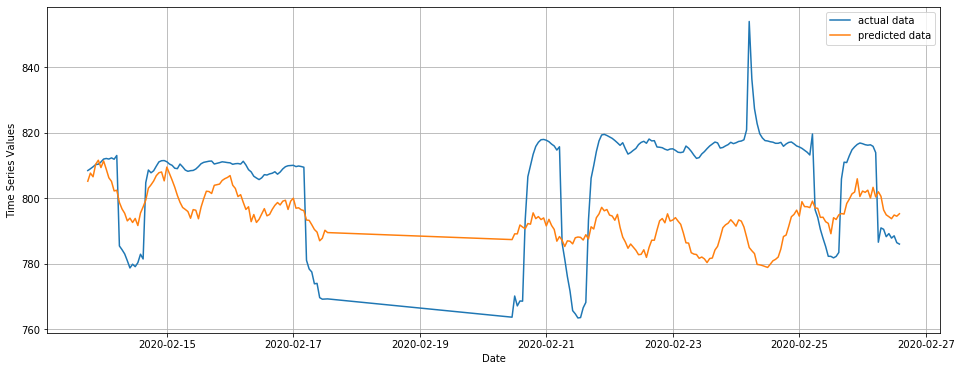

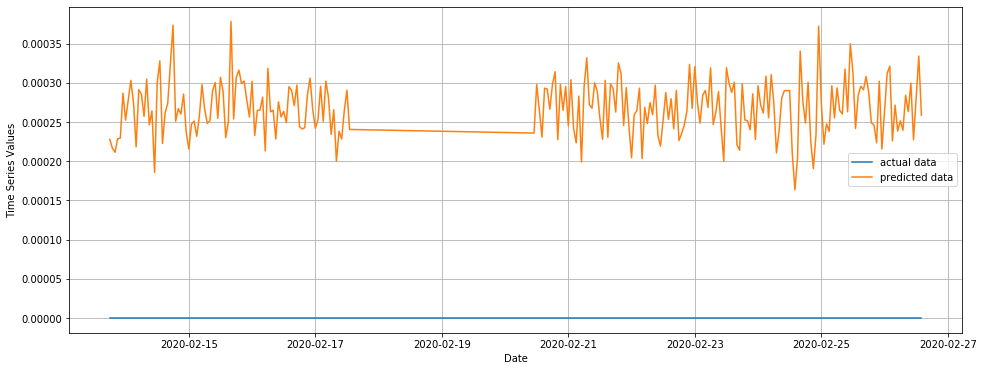

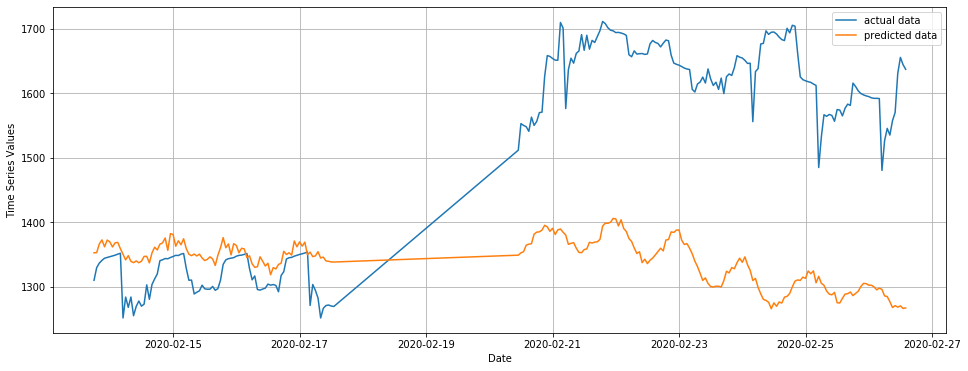

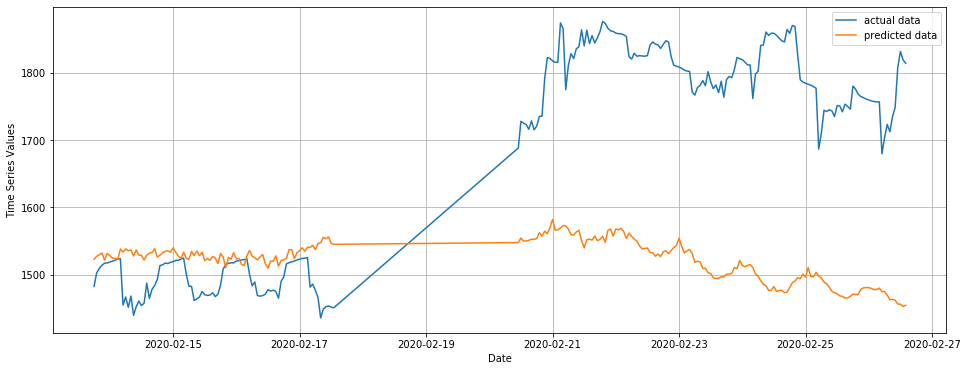

In [16]:
timeDate = testingData.index[-24*10:]
for i in range(9):
    plt.figure(figsize=(16,6))
    plt.plot(timeDate, inv_y[0,i::9].T, label='actual data')
    plt.plot(timeDate, inv_yhat[0,i::9].T, label='predicted data')
    plt.legend()
    plt.grid(True)
    plt.xlabel('Date')
    plt.ylabel('Time Series Values')
    plt.show()

# Bootstrapping

In [83]:
def bootstrap(data, n=1000, func=np.std):
    simulations = list()
    sample_size = len(data)
    xbar_init = np.mean(data)
    for c in range(n):
        itersample = np.random.choice(data, size=sample_size, replace=True)
        simulations.append(func(itersample))
    simulations.sort()
    def ci(p):
        u_pval = (1+p)/2
        l_pval = (1-u_pval)
        l_indx = int(np.floor(n*l_pval))
        u_indx = int(np.floor(n*u_pval))
        return(simulations[l_indx], simulations[u_indx])
    return(ci)

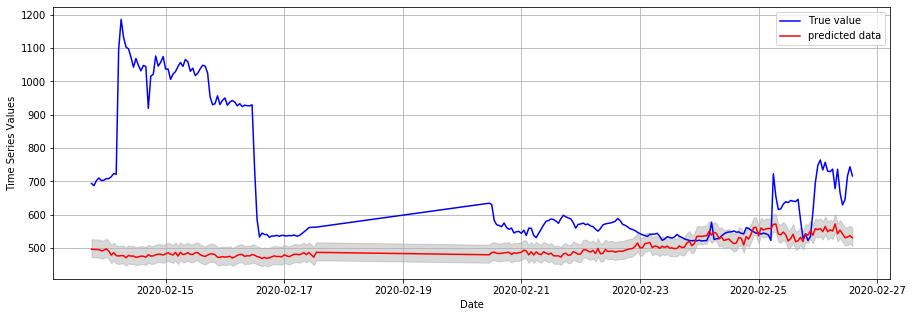

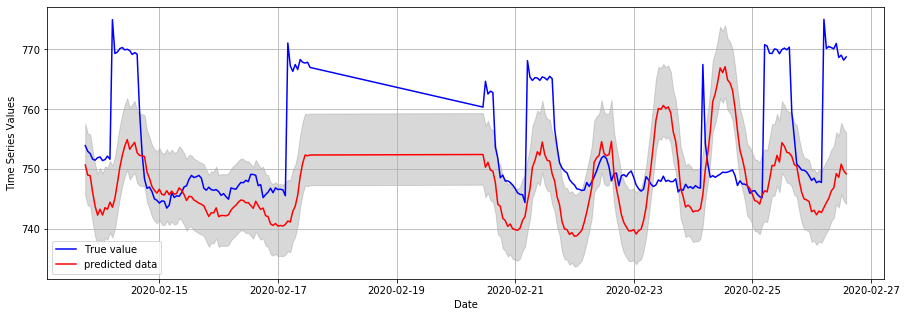

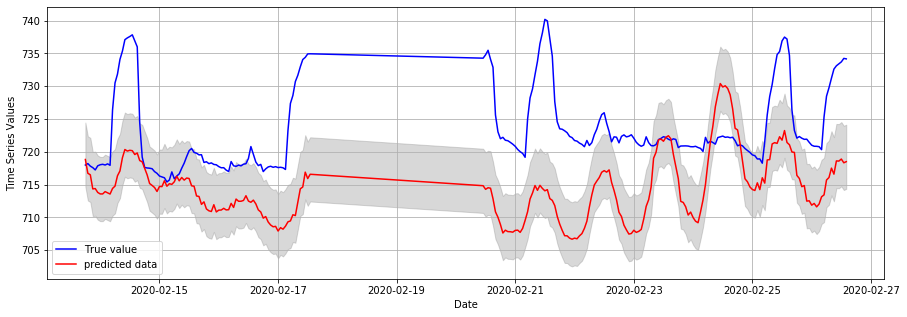

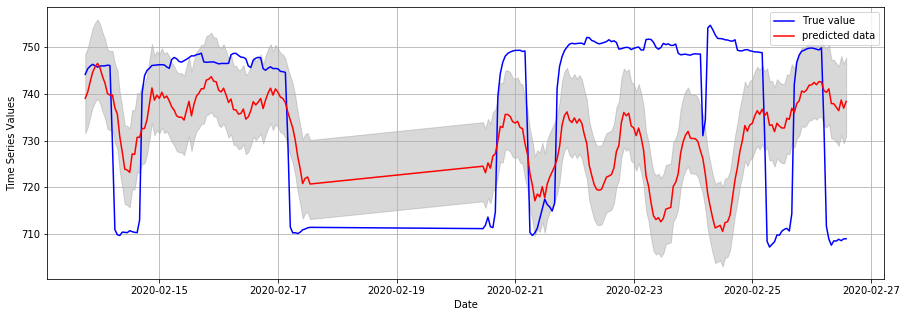

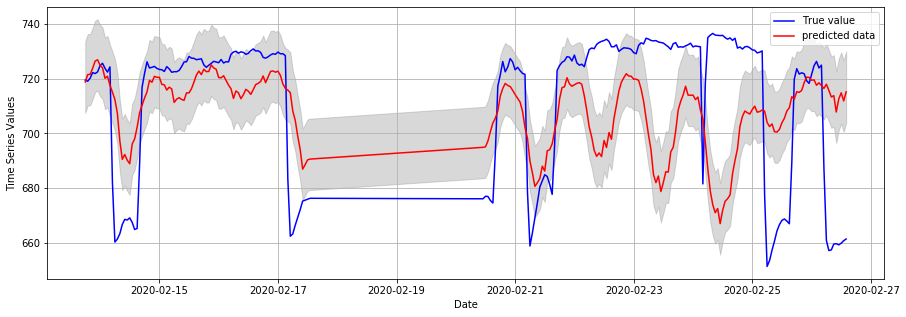

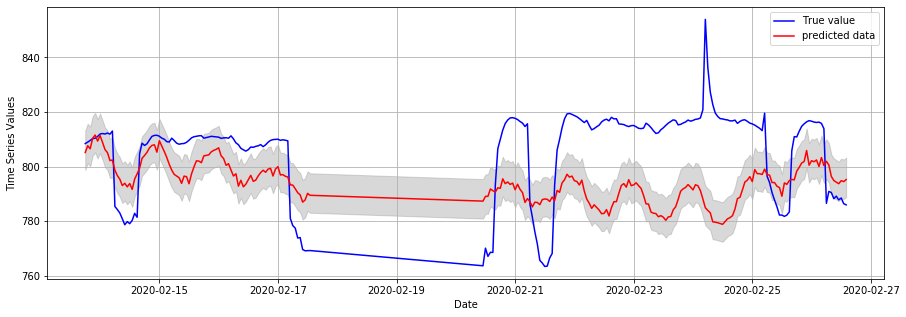

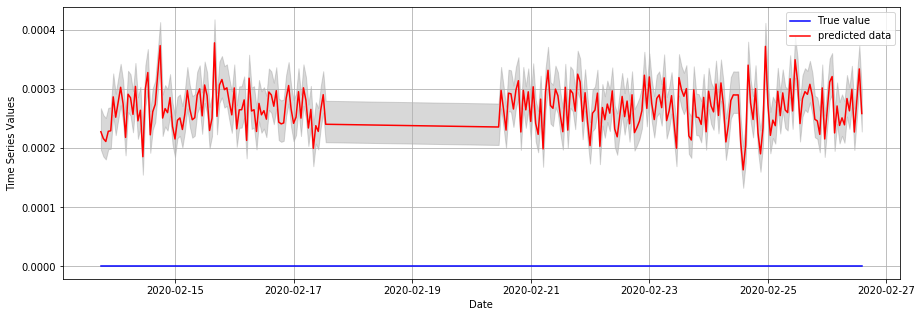

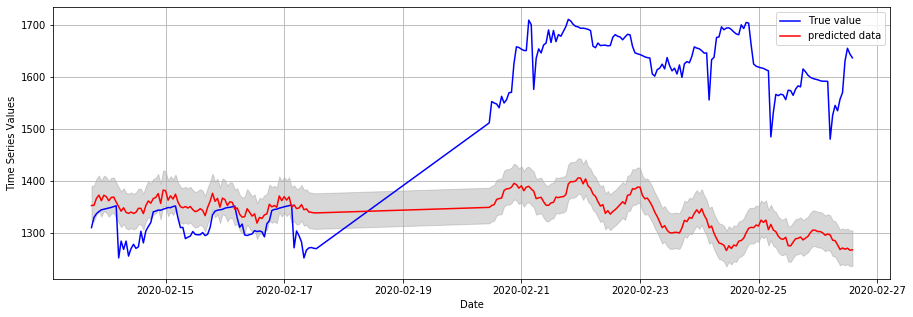

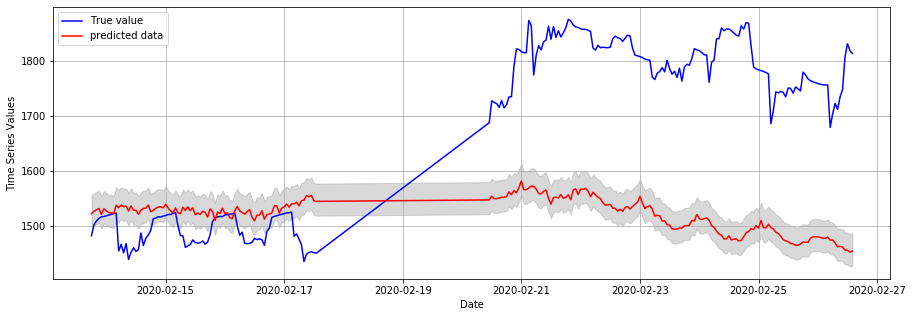

In [92]:
testPlot = testingData.iloc[-24*10:,:].values
for i in range(9):
    boot = bootstrap(inv_yhat[:,i::9].tolist()[0], n = 50000)
    std = boot(.995)

    ci_l = inv_yhat[:,i::9].reshape(1,-1)[0] - std[0]
    ci_u = inv_yhat[:,i::9].reshape(1,-1)[0] + std[1]
    
    plt.figure(figsize=(15, 5))
    plt.plot(timeDate, testPlot[:,i], color='blue', label = 'True value')
    plt.plot(timeDate, inv_yhat[0,i::9].T, color='red', label='predicted data')
    
    plt.fill_between(timeDate, ci_l, ci_u, color='grey', alpha=0.3)
    
    plt.xlabel('Date')
    plt.ylabel('Time Series Values')
    plt.legend()
    plt.grid(True)
    plt.show()